In [178]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
from numba import njit,jit
import time
from matplotlib import pyplot as plt
import yaml
import networkx as nx
import scipy

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.close('all')
cols = ['c','m','b','g','r','y','k']

# Define paths
savepath = Path("/Users/saadjansari/Desktop/Meetings/Flatiron/Flatiron 201112")
path_prefix = Path("/Users/saadjansari/Documents/Projects/Results/AMSOS")
simpaths = [
    path_prefix / "Tactoids/scan_filamin_6400/run/f5_merged",
    path_prefix / "Tactoids/scan_filamin_6400/run/f10_merged",
]
# simpaths = [
#     path_prefix / "Tactoids/n25600/f5_merged",
# ]
cols = cols[0:len(simpaths)]
# resolve paths
for spath in simpaths:
    spath.resolve()

In [117]:
@njit
def unfold_trajectories(crds, boxsize):
    # unfolded trajectory via the shortest route
    # expect input: crds = [time, particle, dim]
    crds2 = np.zeros_like(crds)
    crds2[0,:,:] = crds[0,:,:]
    for idx in np.arange(crds.shape[-1]):
        for ipart in np.arange(crds.shape[1]):
            
            # find amount particle travels frame to frame
            dist = nb_diff( crds[:,ipart,idx])
            k = np.sign( dist) * np.floor( np.absolute(dist)/(0.51*boxsize[idx]))
            dist -= k*boxsize[idx]
            crds2[1:,ipart,idx] = dist.cumsum()+crds[0,ipart,idx]
    return crds2

@njit
def nb_diff(x):
    return x[1:] - x[:-1]

def get_boxsize_pbc(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    if conf:
        box_size[0] = 2*box_size[0]
        box_size[1] = 2*box_size[1]
    return box_size

def find_frames(spath):
    
    def fileKey(f):
        return int( f.parts[-1].split('_')[-1].split('.dat')[0] )
    file_s_last = sorted( list(spath.glob('**/SylinderAscii*')), key=fileKey)
    file_p_last = sorted( list(spath.glob('**/ProteinAscii*')), key=fileKey)
    return file_s_last, file_p_last

def read_dat_sylinder_centers( fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Initialize numpy arrays for data
        pos0 = np.zeros( (len(filecontent)-2,3))
        pos1 = np.zeros( (len(filecontent)-2,3))
        c = np.zeros( (len(filecontent)-2,3))

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []
        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()

            dat = np.array( list(map(float,data[2::])) )
            c[idx,:] = (dat[1:4] + dat[4::])/2            

    return c

def get_nodes_in_clusters( nodes, edge0, edge1, min_size_ratio=0.1):
    # Get largesst connected component
    # nodes is a list of integers representing node indices
    # edge0 / edge1 are the list of nodes that each edge connects to.
    # Indices whose values are -1 are ignored in both edge0 and edge1.

    # Create a graph for filaments
    g = nx.Graph()
    g.add_nodes_from( nodes)

    # add edges to the graph
    for e0,e1 in zip( edge0,edge1):
        if e0 != -1 and e1 != -1:
            g.add_edge(e0, e1)

    # find connected component largest
    cc_sort = sorted(nx.connected_components(g), key=len, reverse=True)
    cc_large = [ii for ii in cc_sort if len(ii) > min_size_ratio*len(nodes)]
    cc = []
    for clus in cc_large:
        cc+=clus

    # also get a boolean array representing nodes that are in the largest cc
    cc_bool = np.zeros(len(nodes), dtype=bool)
    cc_bool[ cc] = True
    return cc, cc_bool

def read_dat_sylinder( fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent)-2, dtype=int)
        rad = np.zeros(len(filecontent)-2)
        pos0 = np.zeros( (len(filecontent)-2,3))
        pos1 = np.zeros( (len(filecontent)-2,3))
        ort = np.zeros( (len(filecontent)-2,3))

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []
        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            gids[idx] = int(data[1])

            dat = np.array( list(map(float,data[2::])) )
            rad[idx] = dat[0]
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]
            xi = pos1[idx,:] - pos0[idx,:]
            ort[idx,:] =  xi/np.sqrt(xi.dot(xi))

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'radius' : rad,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'orientation': list(ort)
        })
    return df

def read_dat_protein( fname):
    # Read a ProetinAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent), dtype=int)
        pos0 = np.zeros( (len(filecontent),3))
        pos1 = np.zeros( (len(filecontent),3))
        link0 = np.zeros( len(filecontent), dtype=int)
        link1 = np.zeros( len(filecontent), dtype=int)

        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            # pdb.set_trace()
            gids[idx] = int(data[1])
            link0[idx] = int(data[9])
            link1[idx] = int(data[10])
            dat = np.array( list(map(float,data[2:9])) )
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'link0': link0,
        'link1': link1
        })
    return df

## Testing efficient methods for MSD calculations


I assume that positions are stored in a (iTime, iParticle, iDim) numpy array.

### The data:

In [174]:
def load_trajectories(spath):

    # Load data
    boxsize = get_boxsize_pbc( spath)

    # Get files for frames
    files_syl, files_prot = find_frames( spath)
    nT = len(files_syl)
    nDim = 3

    # number of particles
    nPar = len( read_dat_sylinder_centers(files_syl[0]))

    # Load position centers and store them in a numpy array
    pos = np.zeros( (nT, nPar, nDim))
    for idx,fil in enumerate( files_syl):
        pos[idx,:,:] = read_dat_sylinder_centers(fil)

    # Load 10 frames for sylinder, protein to get cluster elements
    frr = np.array( np.floor(np.linspace(0,nT-1, 10)), dtype=int)
    cc_bool = np.ones((1,nPar),dtype=bool)
    for fr in frr:
        
        df_sylinder = read_dat_sylinder(files_syl[fr])
        df_protein = read_dat_protein( files_prot[fr])
        cc, cc_booll = get_nodes_in_clusters(
                df_sylinder.gid.tolist(),
                df_protein.link0.tolist(),
                df_protein.link1.tolist(),
                min_size_ratio=0.1)
        cc_bool = np.logical_and(cc_bool, cc_booll)
    
    cc = np.argwhere(cc_bool)[:,1].tolist()
    return pos[:,cc,:], boxsize

### Custom

In [119]:
@njit
def msd_traj_1d(pos):
    result = np.zeros_like(pos)
    deltastop = pos.shape[0]
    for traj in range(pos.shape[1]):
#         for dim in range(pos.shape[2]):
        for delta in range(1,deltastop):
            thisresult = 0
            for i in range(delta,deltastop):
#                 thisresult += (pos[traj,i,dim] - pos[traj,i-delta,dim])**2
                thisresult += (pos[i,traj] - pos[i-delta,traj])**2
#             result[traj,delta,dim] = thisresult / (deltastop - delta)
            result[delta,traj] = thisresult / (deltastop - delta)
    return result

@njit
def msd_traj_3d(pos):
    msd = np.zeros_like(pos)
    for idx in np.arange(pos.shape[-1]):
        msd[:,:,idx] = msd_traj_1d(pos[:,:,idx])
    return msd

### Freud

In [11]:
import freud

def rdf_freud(pos,box_size):
    box = freud.Box(Lx=box_size[0], Ly=box_size[1],Lz=box_size[2])
    rdf = freud.density.RDF(bins=200, r_max=min(box_size)/2.1)
    rdf.compute(system=(box,pos))
    return rdf

def msd_freud(pos,box_size,start=0):
    box = freud.Box(Lx=boxsize[0], Ly=boxsize[1], Lz=boxsize[2])
    msd = freud.msd.MSD(box)
    msd.compute(pos[start:,:,:])
    return msd

# # rdf = rdf_freud(pos[-1,:,:], [3.17,3.17,3.17])
# msd = msd_freud(pos[:,cc,:], [3.17,3.17,3.17],start=500)
# fig, ax = plt.subplots()
# msd.plot(ax=ax)

### Code

In [179]:
msds = []

# Analyze each sim
for spath in simpaths:

    # Load trajectory
    pos, boxsize = load_trajectories(spath)
    
    # Unfold trajectory
    pos_full = unfold_trajectories(pos, boxsize)
    
    # Calculate MSD
    msds.append( msd_traj_3d(pos_full) )

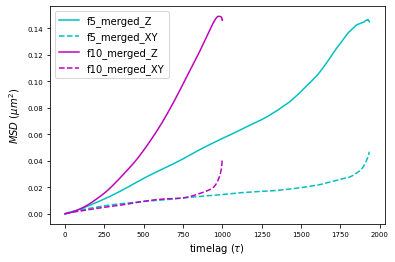

In [241]:
fig,ax = plt.subplots(figsize=(6,4))
for spath, msd, col in zip(simpaths, msds, cols):
    
    # Plot MSD_z
    ax.plot( np.mean(msd[:,:,2], axis=1), label='{0}_Z'.format(spath.name), ls='-', color=col)
    
    ax.plot( 
        np.mean( 0.5*(msd[:,:,0] + msd[:,:,1]), axis=1), 
        label='{0}_XY'.format(spath.name), ls='--', color=col)
    
plt.legend()
ax.set(xlabel=r'timelag ($\tau$)', ylabel=r'$MSD$ ($\mu m^2$)')
plt.savefig( savepath/"Tac_msd.pdf")

#### Find diffusion constant

In [240]:
t0 = 500
t1 = 1500
dt = 0.01

msdZall = np.mean(msds[0][:,:,2], axis=1)
Dz = (msdZall[t1]-msdZall[t0])/(6*dt*(t1-t0))
print('Diffusion constant D_z = {}'.format(Dz))

t0 = 200
t1 = 750
dt = 0.01

msdZall = np.mean(msds[1][:,:,2], axis=1)
Dz = (msdZall[t1]-msdZall[t0])/(6*dt*(t1-t0))
print('Diffusion constant D_z = {}'.format(Dz))

Diffusion constant D_z = 0.0010907102703944232
Diffusion constant D_z = 0.0026323488396527584


### Plot individual trajetories

[Text(0.5, 0, '$\\Delta \\rho$ ($\\mu m$)'),
 Text(0, 0.5, '$\\Delta Z$ ($\\mu m$)')]

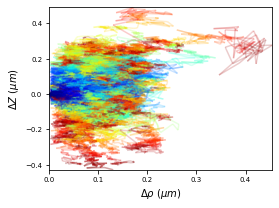

In [239]:
import random
from matplotlib.collections import LineCollection

parts = random.choices(np.arange(pos_full.shape[1]),k=100)
trajs = pos_full[500:,parts,:]
fig,ax = plt.subplots(figsize=(4,3))
xlims = [0,0]
ylims = [0,0]
for idx in range( trajs.shape[1]):
    trajs[:,idx,:] = trajs[:,idx,:] - trajs[0,idx,:]
    tXY = np.sqrt( trajs[:,idx,0]**2 + trajs[:,idx,1]**2)
    tZ = trajs[:,idx,2]

    t = np.linspace(0,1,tXY.shape[0]) # your "time" variable

    # set up a list of (x,y) points
    points = np.array([tXY,tZ]).transpose().reshape(-1,1,2)
    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'), alpha=0.2)
    lc.set_array(t) # color the segments by our parameter

    # plot the collection
    ax.add_collection(lc) # add the collection to the plot
    xlims[0] = min([ tXY.min(), xlims[0]])
    xlims[1] = max([ tXY.max(), xlims[1]])
    ylims[0] = min([ tZ.min(), ylims[0]])
    ylims[1] = max([ tZ.max(), ylims[1]])
    
plt.xlim(xlims[0], xlims[1]) # line collections don't auto-scale the plot
plt.ylim(ylims[0],ylims[1])
ax.set(xlabel=r'$\Delta \rho$ ($\mu m$)', ylabel=r'$\Delta Z$ ($\mu m$)')